In [1]:
import numpy as np
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import cv2
from keras.preprocessing import image
from keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix
import seaborn as sns

2025-03-23 13:40:16.347721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
!rm -rf /kaggle/working/*

zsh:1: no matches found: /kaggle/working/*


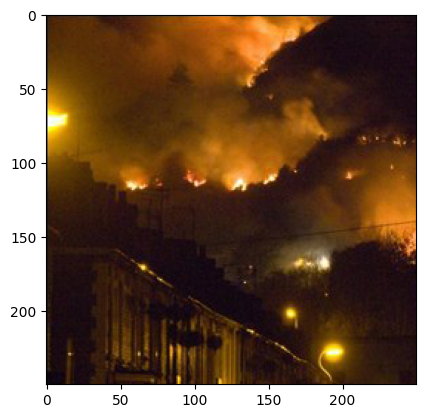

In [10]:
image = cv2.imread(os.path.join('kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training/fire','fire_0001.jpg'))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [12]:
Training = tf.keras.utils.image_dataset_from_directory('kaggle/input/forest-fire-dataset/Forest Fire Dataset/Training',image_size=(250, 250))
# Testing = tf.keras.utils.image_dataset_from_directory('kaggle/input/forest-fire-dataset/Forest Fire Dataset/Testing')

Found 1520 files belonging to 2 classes.


In [13]:
data_iterator = Training.as_numpy_iterator()
# get another batch
batch = data_iterator.next()
batch[1]

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0], dtype=int32)

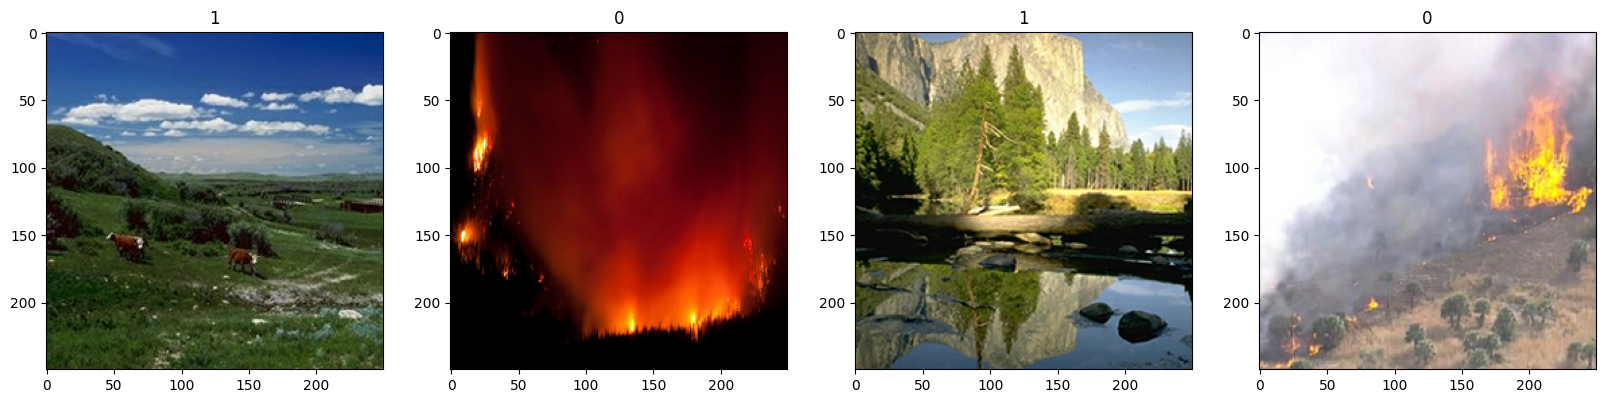

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**Fire = 0**

**No Fire = 1**

In [15]:
Training =Training.map(lambda x,y: (x/255, y))

In [16]:
print(Training)

<_MapDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [17]:
train_size = int(len(Training)*.8)
test_size = int(len(Training)*.2)
print("train_size:",train_size,"test_size:",test_size)

train_size: 38 test_size: 9


In [18]:
train = Training.take(train_size)
test = Training.skip(train_size).take(test_size)
print(train,test)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> <_TakeDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import AdamW

In [20]:
learning_rate = 0.001

model = Sequential()
model.add(Conv2D(250, (3,3),1 , activation='relu', input_shape=(250,250,3)))
model.add(MaxPooling2D())
model.add(Conv2D(125, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(125, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = AdamW(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=tf.losses.binary_crossentropy, metrics=['accuracy'])


/Users/christian/Desktop/MASTER/1 year/Semester 1/SOFTWARE ENGINEERING 2/RESEARCH PROJECT/adaptative-resource-management-ai/flask-app/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 248, 248, 250)  │         7,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 250)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 125)  │       281,375 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 125)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 465125)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 125)            │    58,140,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,429,251 (222.89 MB)

 Trainable params: 58,429,251 (222.89 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=1, validation_data=test,callbacks=[tensorboard_callback])

38/38 ━━━━━━━━━━━━━━━━━━━━ 701s 18s/step - accuracy: 0.8878 - loss: 0.3246 - val_accuracy: 0.9201 - val_loss: 0.1793


In [26]:
model.save("forest_fire.keras")

In [ ]:
model = load_model('kaggle/input/forest-fire/keras/v1/1/forest_fire.keras')

In [19]:
test_folder = '/kaggle/input/forest-fire-dataset/Forest Fire Dataset/Testing'

In [20]:
import os
import shutil

# Define source directory
source_directory = test_folder

# Define destination directories
fire_directory = '/kaggle/working/Testing/fire'
nofire_directory = '/kaggle/working/Testing/nofire'

# Create fire and nofire directories if they don't exist
os.makedirs(fire_directory, exist_ok=True)
os.makedirs(nofire_directory, exist_ok=True)

# Iterate through files in the source directory
for filename in os.listdir(source_directory):
    source_path = os.path.join(source_directory, filename)
    if filename.startswith('fire_'):
        shutil.copy(source_path, os.path.join(fire_directory, filename))
    elif filename.startswith('nofire_'):
        shutil.copy(source_path, os.path.join(nofire_directory, filename))

print("Images moved successfully.")

Images moved successfully.


In [21]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [22]:
Testing = tf.keras.utils.image_dataset_from_directory('/kaggle/working/Testing',image_size=(250,250))

Found 380 files belonging to 2 classes.


In [23]:
for batch in Testing.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2024-04-28 16:58:02.104471: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[28,125,122,122]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,250,124,124]{3,2,1,0}, f32[125,250,3,3]{3,2,1,0}, f32[125]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-04-28 16:58:02.140607: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.036238318s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[28,125,122,122]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,250,124,124]{3,2,1,0}, f32[125,250,3,3]{3,2,1,0}, f32[125]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a whil

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


In [24]:
print(f'Precision:{pre.result()},Recall:{re.result()},Accuracy:{acc.result()}')

Precision:0.9833333492279053,Recall:0.9315789341926575,Accuracy:0.9578947424888611


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


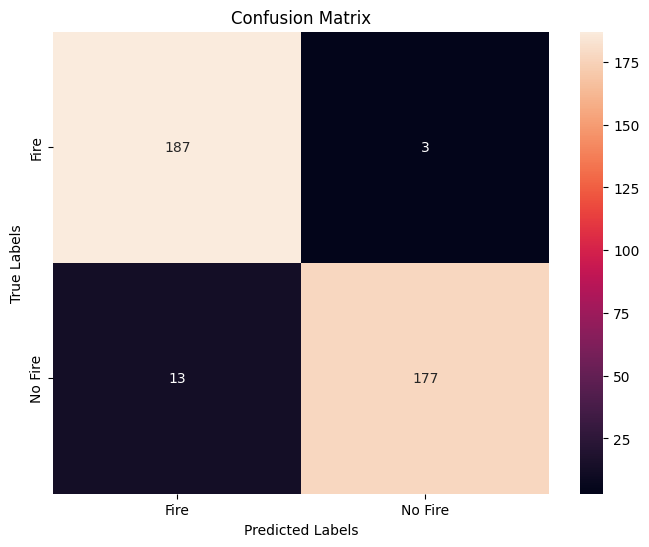

In [25]:
# Initialize the lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation data
for batch in Testing.as_numpy_iterator():
    X, y = batch
    
    # Predict using the model
    yhat = model.predict(X)
    
    # Convert predicted probabilities to class labels based on threshold
    y_classes = [1 if pred > 0.5 else 0 for pred in yhat]
    
    # Update true and predicted labels lists
    true_labels.extend(y)
    predicted_labels.extend(y_classes)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
labels = ['Fire', 'No Fire']
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show() 